In [34]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import IPython.core
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [3]:
def contour_check(teste_x, modelo):
    
    """Facilita a verificação de qual a função obtida pelo modelo nesse contexto 2D.

    Args:
        teste_x (dataframe): Dataframe com os pontos de teste
        modelo (scikit model): Modelo para gerar os pontos previstos.
    """
    
    x_min = teste_x.horas_esperadas.min()
    x_max = teste_x.horas_esperadas.max()
    y_min = teste_x.preco.min()
    y_max = teste_x.preco.max()
    
    pixels = 100
    eixo_x = np.linspace(x_min, x_max, pixels)
    eixo_y = np.linspace(y_min, y_max, pixels)
    
    xx, yy = np.meshgrid(eixo_x, eixo_y)
    pontos = np.c_[xx.ravel(), yy.ravel()]
    
    Z = modelo.predict(pontos)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(teste_x.horas_esperadas, teste_x.preco, c=teste_y, s=1)
    plt.show()
    
    pass

In [4]:
np.random.seed(5)

# 01. Introdução à Classificação

In [5]:
# Features: [pelo longo?, perna curta?, faz auau?]

porco1 = [0, 1, 0]
porco2 = [0, 1, 1]
porco3 = [1, 1, 0]

cachorro1 = [0, 1, 1]
cachorro2 = [1, 0, 1]
cachorro3 = [1, 1, 1]

treino_x = [porco1, porco2, porco3, cachorro1, cachorro2, cachorro3]
treino_y = [1, 1, 1, 0, 0, 0]  # 1 --> porco, 0 --> cachorro

In [6]:
# Geração do objeto LinearSVC e realização do fit do modelo
model = LinearSVC()
model.fit(X=treino_x, y=treino_y)

LinearSVC()

In [7]:
animal_misterioso = [1, 1, 1]
model.predict([animal_misterioso])
# 0 == cachorro

array([0])

In [8]:
# Conjunto de testes
misterio1 = [1, 1, 1]
misterio2 = [1, 1, 0]
misterio3 = [0, 1, 1]

teste_x = [misterio1, misterio2, misterio3]
teste_y = [0, 1, 1]

previsoes = model.predict(teste_x)

In [10]:
# Taxa de acerto manual
taxa_de_acerto = (previsoes == teste_y).sum()/len(teste_x)
print('Taxa de acerto: %.2f' %(taxa_de_acerto*100), '%')

Taxa de acerto: 66.67 %


In [11]:
# Taxa de acerto pelo scikit-learn
taxa_de_acerto = accuracy_score(y_true=teste_y, y_pred=previsoes)
print('Taxa de acerto: %.2f' %(taxa_de_acerto*100), '%')

Taxa de acerto: 66.67 %


# 02. Testes replicáveis, estratificação e lendo dados da internet

In [12]:
uri='https://gist.githubusercontent.com/guilhermesilveira/2d2efa37d66b6c84a722ea627a897ced/raw/10968b997d885cbded1c92938c7a9912ba41c615/tracking.csv'
dados = pd.read_csv(uri)

In [13]:
print(dados.shape)
dados.head()

(99, 4)


,home,how_it_works,contact,bought
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,1,0,0


In [14]:
# Renomeando para português
col_nomes = {
    'home' : 'principal',
    'how_it_works' : 'como_funciona',
    'contact' : 'contato',
    'bought' : 'comprou'
}
dados = dados.rename(columns=col_nomes)

In [15]:
# Atrubuindo X e y; separando entre teste e treino (75%/25%)
x = dados[['principal', 'como_funciona', 'contato']]
y = dados['comprou']

treino_x = x[:75]
treino_y = y[:75]
teste_x = x[75:]
teste_y = y[75:]

In [16]:
# Input no modelo e acurácia
modelo = LinearSVC()
modelo.fit(treino_x, treino_y)

previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f'Foi obtida uma acurácia de {round(acuracia*100, 2)}%.')

Foi obtida uma acurácia de 95.83%.


In [17]:
## Usando a biblioteca para fazer a separação entre treino e teste:

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.25, stratify=y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

modelo = LinearSVC()
modelo.fit(treino_x, treino_y)

previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f'Foi obtida uma acurácia de {round(acuracia*100, 2)}%.')

Treinaremos com 74 elementos e testaremos com 25 elementos.
Foi obtida uma acurácia de 100.0%.


# 03. Um projeto de baixa dimensionalidade e o baseline

In [18]:
uri= 'https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv'
dados = pd.read_csv(uri)

print(dados.shape)
dados.head()

(2157, 3)


,unfinished,expected_hours,price
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


In [19]:
# Renomear para português
col_nomes = {
    'unfinished' : 'nao_finalizado',
    'expected_hours' : 'horas_esperadas',
    'price' : 'preco'
}

dados = dados.rename(columns=col_nomes)

In [20]:
# Trocar 'nao_finalizado' por 'finalizado'; mais natural de trabalhar
dados['finalizado'] = (~(dados['nao_finalizado'].astype(bool))).astype(int)

print(dados.finalizado.value_counts())
print(dados.nao_finalizado.value_counts())

dados = dados.drop(columns=['nao_finalizado'])
dados.head()

1    1134
0    1023
Name: finalizado, dtype: int64
0    1134
1    1023
Name: nao_finalizado, dtype: int64


,horas_esperadas,preco,finalizado
0,26,192,0
1,88,9015,0
2,89,2577,0
3,42,275,0
4,39,170,0


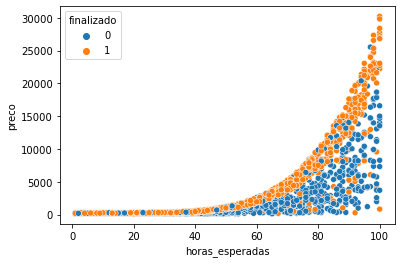

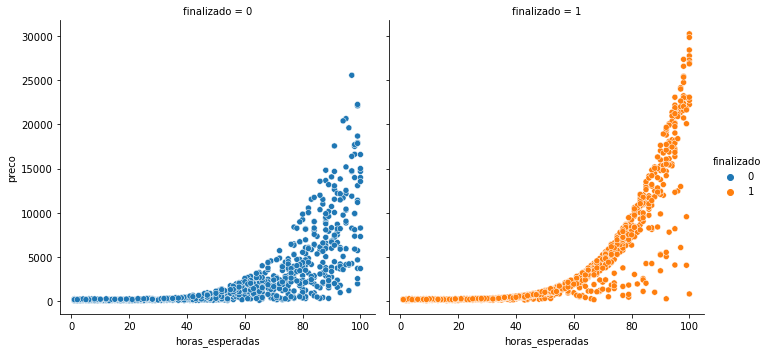

In [21]:
# Plots com:
#    - Todos os pontos coloridos por finalização ou não; pontos separados para notar a diferença da curva

sns.scatterplot(data=dados, x='horas_esperadas', y='preco', hue='finalizado')
sns.relplot(data=dados, x='horas_esperadas', y='preco', hue='finalizado', col='finalizado')

In [22]:
nomes_x = ['horas_esperadas', 'preco']
x = dados[nomes_x]
y = dados['finalizado']

modelo = LinearSVC()
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.25, stratify=y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f'Foi obtida uma acurácia de {round(acuracia*100, 2)}%.')

Treinaremos com 1617 elementos e testaremos com 540 elementos.
Foi obtida uma acurácia de 47.41%.


C:\Users\Adolfo\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [23]:
previsoes_baseline = np.ones(540)
acuracia = accuracy_score(teste_y, previsoes_baseline)
print(f'A acurácia de baseline foi {round(acuracia*100, 2)}%.')

A acurácia de baseline foi 52.59%.


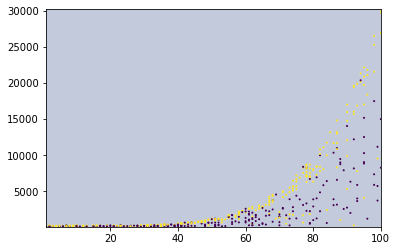

In [24]:
# Observando o decision boundary para descobrir o porquê da acurácia estar baixa
contour_check(teste_x, modelo)

# 04. Support Vector Machine e a não linearidade

Treinaremos com 1617 elementos e testaremos com 540 elementos.
Foi obtida uma acurácia de 54.63%.


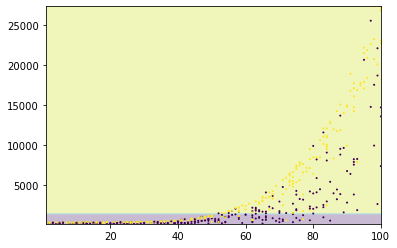

In [25]:
# Dados sem padronização
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f"Foi obtida uma acurácia de {round(acuracia*100, 2)}%.")

contour_check(teste_x, modelo)

Treinaremos com 1617 elementos e testaremos com 540 elementos.
Foi obtida uma acurácia de 69.81%.


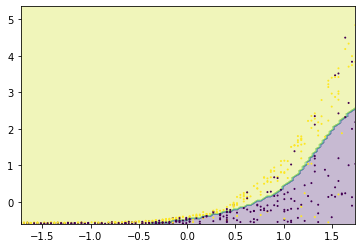

In [26]:
# Padronizando o conjunto de dados

raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f"Foi obtida uma acurácia de {round(acuracia*100, 2)}%.")

contour_check(pd.DataFrame(teste_x, columns=nomes_x), modelo)

# 05. Dummy classifiers e árvore de decisão

In [27]:
uri = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'
dados = pd.read_csv(uri)
print(dados.shape)

dados.head()

(10000, 5)


,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


In [28]:
# Fazer algumas modificações no conjunto de dados:
#    - Renomear para português; milhas -> km; ano do modelo -> idade do modelo; (yes, no) -> (1, 0)

nomes = {
    'mileage_per_year' : 'milhas_por_ano',
    'model_year' : 'ano_do_modelo',
    'price' : 'preco',
    'sold' : 'vendido'
}

vendido_map = {
    'yes' : 1,
    'no' : 0
}

dados = dados.rename(columns=nomes)
dados['km_por_ano'] = dados.milhas_por_ano*1.609344
dados['idade_do_modelo'] = datetime.today().year - dados.ano_do_modelo
dados.vendido = dados.vendido.map(vendido_map)

dados = dados.drop(columns=['Unnamed: 0', 'milhas_por_ano', 'ano_do_modelo'])
dados.head()

,preco,vendido,km_por_ano,idade_do_modelo
0,30941.02,1,35085.308544,22
1,40557.96,1,12622.084992,24
2,89627.50,0,11440.826496,16
3,95276.14,0,43167.434112,7
4,117384.68,1,12770.144640,8


In [29]:
# Testando resultado com LinearSVC
x = dados[['preco', 'km_por_ano', 'idade_do_modelo']]
y = dados['vendido']

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

modelo = LinearSVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f"Foi obtida uma acurácia de {round(acuracia*100, 2)}%.")

Treinaremos com 7500 elementos e testaremos com 2500 elementos.
Foi obtida uma acurácia de 61.96%.


C:\Users\Adolfo\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [30]:
# Obtendo a acurácia de baseline por meio do Dummy Classifier
dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y)

print(f"O dummy classifier obteve uma acurácia de {round(acuracia*100, 2)}%.")

O dummy classifier obteve uma acurácia de 58.0%.


In [31]:
# Testando resultado com SVC
raw_treino_x, raw_teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

scaler = StandardScaler()
scaler.fit(raw_treino_x)
treino_x = scaler.transform(raw_treino_x)
teste_x = scaler.transform(raw_teste_x)

modelo = SVC()
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f"Foi obtida uma acurácia de {round(acuracia*100, 2)}%.")

Treinaremos com 7500 elementos e testaremos com 2500 elementos.
Foi obtida uma acurácia de 77.08%.


Treinaremos com 7500 elementos e testaremos com 2500 elementos.
Foi obtida uma acurácia de 78.32%.


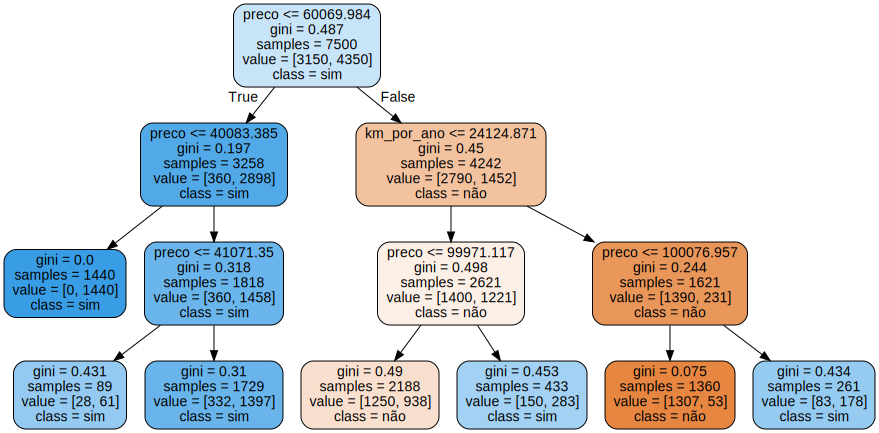

In [35]:
# Testando árvores de decisão e observando os critérios para tomada de decisão
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify = y)
print(f"Treinaremos com {len(treino_x)} elementos e testaremos com {len(teste_x)} elementos.")

modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes)
print(f"Foi obtida uma acurácia de {round(acuracia*100, 2)}%.")

# Obtendo a imagem da árvore para visualização
features = x.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                           feature_names=features, class_names=["não", "sim"])
grafico = graphviz.Source(dot_data)
display(grafico)